## Mortality Training
1. Load the MIMIC III Dataset
2. Normalize Data
3. Load into Pytorch Dataloader
4. Train
5. Evaluate

In [1]:
from os import path

from comet_ml import Experiment
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from core.model import SAnD
from mimic3_benchmarks.mimic3benchmark.readers import InHospitalMortalityReader as Reader
from mimic3_benchmarks.mimic3models.preprocessing import Discretizer, Normalizer
from utils.ihm_utils import evaluate_predictions, load_data, save_results
from utils.functions import get_weighted_sampler, get_weights
from utils.trainer import NeuralNetworkClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
task = "in-hospital-mortality"

## Load Data
Using the [MimicIII Benchmark's](https://github.com/YerevaNN/mimic3-benchmarks) InHospitalMortalityReader and associated functions, load the data into memory.

If you are following along you will need to arrange the data following the directions on the link.


In [2]:
train_reader = Reader(dataset_dir=f"mimic3_benchmarks/data/{task}/train",
                              listfile=f"mimic3_benchmarks/data/{task}/train_listfile.csv")
val_reader = Reader(dataset_dir=f"mimic3_benchmarks/data/{task}/train",
                              listfile=f"mimic3_benchmarks/data/{task}/val_listfile.csv")
test_reader = Reader(dataset_dir=f"mimic3_benchmarks/data/{task}/test",
                              listfile=f"mimic3_benchmarks/data/{task}/test_listfile.csv")

### Example data

In [3]:
ex = pd.DataFrame.from_dict(train_reader.read_example(0)['X'])
ex.columns = train_reader.read_example(0)["header"]
ex

,Hours,Capillary refill rate,Diastolic blood pressure,Fraction inspired oxygen,Glascow coma scale eye opening,Glascow coma scale motor response,Glascow coma scale total,Glascow coma scale verbal response,Glucose,Heart Rate,Height,Mean blood pressure,Oxygen saturation,Respiratory rate,Systolic blood pressure,Temperature,Weight,pH
0,0.2138888888888889,,71.0,,,,,,,94,,95,92.0,16,141.0,,,
1,0.46388888888888885,,71.0,,,,,,,91,,95,93.0,16,141.0,,,
2,0.7138888888888889,,,,,,,,,89,,,93.0,19,,,,
3,0.9638888888888889,,,,,,,,,89,,,94.0,13,,,,
4,1.1305555555555555,,,,,,,,,,,,,,,,,7.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,44.21388888888889,,58.0,,,,,,,103,,81,99.0,21,113.0,,,
67,45.21388888888889,,59.0,,4 Spontaneously,6 Obeys Commands,15,5 Oriented,,107,,81,97.0,22,116.0,,,
68,46.21388888888889,,61.0,,,,,,,100,,85,97.0,20,120.0,,,
69,47.21388888888889,,58.0,,,,,,,90,,83,100.0,18,123.0,37.0,,


### Normalize and Discretize data
From the MIMIC-III Benchmark repo

In [4]:
discretizer = Discretizer(timestep=1.0,
                          store_masks=True,
                          impute_strategy='previous',
                          start_time='zero')

discretizer_header = discretizer.transform(train_reader.read_example(0)["X"])[1].split(',')
cont_channels = [i for (i, x) in enumerate(discretizer_header) if x.find("->") == -1]

In [5]:
normalizer = Normalizer(fields=cont_channels)  # choose here which columns to standardize
normalizer_state = 'train/ihm_ts1.0.input_str-previous.start_time-zero.normalizer'
normalizer.load_params(normalizer_state)

In [6]:
train_raw = load_data(train_reader, discretizer, normalizer)
val_raw = load_data(val_reader, discretizer, normalizer)
test_data = load_data(test_reader, discretizer, normalizer, return_names=True)
test_raw = test_data["data"]
test_names = test_data["names"]

N, seq_len, feature_count = train_raw[0].shape

In [14]:
batch_size = 256

train_ds = TensorDataset(train_raw[0], train_raw[1])
val_ds = TensorDataset(val_raw[0], val_raw[1])
test_ds = TensorDataset(test_raw[0], test_raw[1])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size)
print(len(test_raw[1]))
print(test_loader.dataset.tensors[1].shape)

3236
torch.Size([3236])


## Create model, Train, and Evaluate
Train the model, this will export results to Comet ML.
Creating is done in the same step such that a new experiment made each time
Evaluation is done in the same step such that the Comet ML experiment is also deleted.

### Paper IHM Module

In [ ]:
n_heads = 8
factor = 12 # M
num_class = 2
num_layers = 4 # N
epochs = 28
betas = (0.9, 0.98)
lr = 5e-4
eps = 4e-09
weight_decay = 5e-4
dropout = 0.3
scores = {}

experiment = Experiment(
    api_key="eQ3INeSsFGUYKahSdEtjhry42",
    project_name="general",
    workspace="samdoud",
)
clf = NeuralNetworkClassifier(
    SAnD(feature_count, seq_len, n_heads, factor, num_class, num_layers, dropout_rate=dropout),
    nn.CrossEntropyLoss(),
    optim.Adam, optimizer_config={
        "lr": lr, "betas": betas, "eps": eps, "weight_decay": weight_decay},
    experiment=experiment,
)
# Score is the multiplication of AUPRC and AUROC
score = clf.fit(
    {
        "train": train_loader,
        "val": val_loader
    },
    validation=True,
    epochs=epochs,
    verbose=True,
)

preds = clf.evaluate(test_loader)

experiment.end()

file_path = 'results/test_predictions.csv'
save_results(test_names, preds, test_raw[1], file_path)
pred_df = pd.read_csv(file_path, index_col=False)
list_df = pd.read_csv(f"mimic3_benchmarks/data/{task}/test_listfile.csv", index_col=False)

evaluate_predictions(pred_df, list_df, save_file="results/paper_ihm.json")

In [15]:
n_heads = 8
factor = 12 # M
num_class = 2
num_layers = 4 # N
epochs = 12
betas = (0.9, 0.98)
lr = 0.0005
eps = 4e-09
weight_decay = 5e-4
dropout = 0.3
scores = {}

experiment = Experiment(
    api_key="eQ3INeSsFGUYKahSdEtjhry42",
    project_name="general",
    workspace="samdoud",
    auto_output_logging=False,
)
for iteration, level in enumerate(np.logspace(0, .75, 30)):
    clf = NeuralNetworkClassifier(
        SAnD(feature_count, seq_len, n_heads, factor, num_class, num_layers, dropout_rate=dropout),
        nn.CrossEntropyLoss(weight=torch.tensor(get_weights(train_raw[1], level=level), dtype=torch.float32).to(device=device)),
        optim.Adam, optimizer_config={
            "lr": lr, "betas": betas, "eps": eps, "weight_decay": weight_decay},
        experiment=experiment,
        silent=True,
    )
    # Score is the multiplication of AUPRC and AUROC
    scores[level] = clf.fit(
        {
            "train": DataLoader(train_ds, batch_size=batch_size, shuffle=False),
            "val": val_loader
        },
        validation=True,
        epochs=epochs,
        verbose=True,
        level=iteration
    )
    print(scores[level])

    #clf.evaluate(test_loader)

experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/samdoud/general/b4bf309fb70545c6aa87d3d6b8175934



(0.6340095937462535, 0.5864663884855132, 0.7290960042677345)


COMET WARNING: Cannot safely convert (0.6283524102502456, 0.5669025327999752, 0.7512521651507866) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6283524102502456, 0.5669025327999752, 0.7512521651507866)


COMET WARNING: Cannot safely convert (0.6217623921634763, 0.574098734224126, 0.7170897080421769) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6217623921634763, 0.574098734224126, 0.7170897080421769)


COMET WARNING: Cannot safely convert (0.6320160082283492, 0.5730548842643874, 0.7499382561562729) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6320160082283492, 0.5730548842643874, 0.7499382561562729)


COMET WARNING: Cannot safely convert (0.6178481140520711, 0.5539295009779335, 0.7456853402003464) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6178481140520711, 0.5539295009779335, 0.7456853402003464)


COMET WARNING: Cannot safely convert (0.6421928383502372, 0.5829056059779728, 0.7607673030947661) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6421928383502372, 0.5829056059779728, 0.7607673030947661)


COMET WARNING: Cannot safely convert (0.6240889790268777, 0.5756144580224586, 0.7210380210357159) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6240889790268777, 0.5756144580224586, 0.7210380210357159)


COMET WARNING: Cannot safely convert (0.6220815520752839, 0.5784800966410185, 0.7092844629438149) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6220815520752839, 0.5784800966410185, 0.7092844629438149)


COMET WARNING: Cannot safely convert (0.6288233813019399, 0.5708332528969485, 0.7448036381119226) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6288233813019399, 0.5708332528969485, 0.7448036381119226)


COMET WARNING: Cannot safely convert (0.6285921926929029, 0.5657671821945142, 0.7542422136896804) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6285921926929029, 0.5657671821945142, 0.7542422136896804)


COMET WARNING: Cannot safely convert (0.6149044025016279, 0.5505512302268849, 0.7436107470511141) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6149044025016279, 0.5505512302268849, 0.7436107470511141)


COMET WARNING: Cannot safely convert (0.6236890115995066, 0.5620215440330844, 0.7470239467323511) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6236890115995066, 0.5620215440330844, 0.7470239467323511)


COMET WARNING: Cannot safely convert (0.6289165369842625, 0.574212480087984, 0.7383246507768199) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6289165369842625, 0.574212480087984, 0.7383246507768199)


COMET WARNING: Cannot safely convert (0.6223242163773419, 0.5568505243328682, 0.7532716004662895) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6223242163773419, 0.5568505243328682, 0.7532716004662895)


COMET WARNING: Cannot safely convert (0.63095971650158, 0.5676485027475228, 0.7575821440096946) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.63095971650158, 0.5676485027475228, 0.7575821440096946)


COMET WARNING: Cannot safely convert (0.629103653741232, 0.5647503883089179, 0.7578101846058602) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.629103653741232, 0.5647503883089179, 0.7578101846058602)


COMET WARNING: Cannot safely convert (0.6256255283482753, 0.5680456181413334, 0.7407853487621594) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6256255283482753, 0.5680456181413334, 0.7407853487621594)


COMET WARNING: Cannot safely convert (0.6291264880475558, 0.5750855710302172, 0.737208322082233) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6291264880475558, 0.5750855710302172, 0.737208322082233)


COMET WARNING: Cannot safely convert (0.6217216953181838, 0.5644134702216232, 0.7363381455113049) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6217216953181838, 0.5644134702216232, 0.7363381455113049)


COMET WARNING: Cannot safely convert (0.6166150200500178, 0.549908123178157, 0.7500288137937393) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6166150200500178, 0.549908123178157, 0.7500288137937393)


COMET WARNING: Cannot safely convert (0.6062159411647637, 0.5387324221892645, 0.7411829791157623) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6062159411647637, 0.5387324221892645, 0.7411829791157623)


COMET WARNING: Cannot safely convert (0.6090057820020129, 0.5417354062762006, 0.7435465334536377) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6090057820020129, 0.5417354062762006, 0.7435465334536377)


COMET WARNING: Cannot safely convert (0.6143798579389684, 0.5493659597780431, 0.7444076542608192) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6143798579389684, 0.5493659597780431, 0.7444076542608192)


COMET WARNING: Cannot safely convert (0.621757757298843, 0.5596782990475091, 0.7459166738015108) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.621757757298843, 0.5596782990475091, 0.7459166738015108)


COMET WARNING: Cannot safely convert (0.6293801706300879, 0.5767618923710359, 0.7346167271481918) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6293801706300879, 0.5767618923710359, 0.7346167271481918)


COMET WARNING: Cannot safely convert (0.6190779134743193, 0.5531430891172793, 0.7509475621883993) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6190779134743193, 0.5531430891172793, 0.7509475621883993)


COMET WARNING: Cannot safely convert (0.6233031512614262, 0.5713407033010516, 0.7272280471821755) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6233031512614262, 0.5713407033010516, 0.7272280471821755)


COMET WARNING: Cannot safely convert (0.6296186825810423, 0.5747272921658527, 0.7394014634114214) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6296186825810423, 0.5747272921658527, 0.7394014634114214)


COMET WARNING: Cannot safely convert (0.6186103920673649, 0.5558500671805867, 0.7441310418409215) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6186103920673649, 0.5558500671805867, 0.7441310418409215)


COMET WARNING: Cannot safely convert (0.6138143080732188, 0.5465801131632606, 0.7482826978931354) object to a scalar value, using its string representation for logging. Resulting string might be invalid
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/samdoud/general/b4bf309fb70545c6aa87d3d6b8175934
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     AUPRCxAUROC                 : (0.6138143080732188, 0.5465801131632606, 0.7482826978931354)
COMET INFO:     train_AUPRC [20880]         : (0.06640625, 0.7324182205041581)
COMET INFO:     train_AUROC [20880]         : (0.4291202967673556, 0.8382389238553623)
COMET INFO:     train_MSE [20880]           : (0.07552083333333333, 0.8671875)
COMET INFO:     train_accuracy [20880]      : (0.1328125, 0.9244791666666666)
COMET INFO:     train_loss [2262

(0.6138143080732188, 0.5465801131632606, 0.7482826978931354)


COMET INFO: Uploading 1 metrics, params and output messages


In [27]:
results = {level: score for level, score in sorted(scores.items(), key=lambda item: item[1], reverse=True)}
max_level = list(results.keys())[0]
for level, score in results.items():
    print(f"{level}: AUROC/3 + 2/3 * AUPRC {score[0]}; AUPRC {score[1]}; AUROC {score[2]}")

IndexError: list index out of range

In [38]:
n_heads = 8
factor = 12 # M
num_class = 2
num_layers = 4 # N
epochs = 50
betas = (0.9, 0.98)
lr = 1e-5
eps = 4e-09
weight_decay = 1e-4
dropout = 0.667
scores = {}

experiment = Experiment(
    api_key="eQ3INeSsFGUYKahSdEtjhry42",
    project_name="general",
    workspace="samdoud",
)
clf = NeuralNetworkClassifier(
    SAnD(feature_count, seq_len, n_heads, factor, num_class, num_layers, dropout_rate=dropout),
    nn.CrossEntropyLoss(weight=torch.tensor(get_weights(train_raw[1], level=max_level), dtype=torch.float32).to(device=device)),
    optim.Adam, optimizer_config={
        "lr": lr, "betas": betas, "eps": eps, "weight_decay": weight_decay},
    experiment=experiment,
)
# Score is the multiplication of AUPRC and AUROC
clf.fit(
    {
        "train": train_loader,
        "val": val_loader
    },
    validation=True,
    epochs=epochs,
    verbose=True,
)

preds = clf.evaluate(test_loader)

experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/samdoud/general/8dff5d1ca0af4219bb19dc005a3df292
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_AUPRC [19]    : (0.17141604649631192, 0.36658184606660354)
COMET INFO:     train_AUROC [19]    : (0.44832775919732437, 0.5732287356115606)
COMET INFO:     train_MSE [19]      : (0.34681919642857145, 0.39208984375)
COMET INFO:     train_accuracy [19] : (0.60791015625, 0.6531808035714286)
COMET INFO:     train_loss [20]     : (1.973168969154358, 3.6265432834625244)
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 256
COMET INFO:     betas         : (0.9, 0.98)
COMET INFO:     epochs        : 50
COMET INFO:     eps           : 4e-09
COMET INFO:     lr            : 1e-05
COMET INFO:     train_ds_size : 14681
COMET INFO:     val_ds

Train finished. Accuracy: 0.6254 MSE: 0.3746 AUROC: 0.5476 AUPRC: 0.3415


Training - Epochs: 001/050: 100%|██████████| 14681/14681 [00:03<00:00, 4150.50it/s]


Validation finished. Accuracy: 0.6946 MSE: 0.0670 AUROC: 0.6386 AUPRC: 0.4286


Training - Epochs: 001/050:  35%|███▍      | 5120/14681 [00:16<00:02, 4182.89it/s]

Train finished. Accuracy: 0.6922 MSE: 0.3078 AUROC: 0.6248 AUPRC: 0.4117


Training - Epochs: 002/050: 100%|██████████| 14681/14681 [00:03<00:00, 4132.63it/s]


Validation finished. Accuracy: 0.7812 MSE: 0.0480 AUROC: 0.6655 AUPRC: 0.4422


Train finished. Accuracy: 0.7001 MSE: 0.2999 AUROC: 0.6370 AUPRC: 0.4245


Training - Epochs: 003/050: 100%|██████████| 14681/14681 [00:03<00:00, 4105.49it/s]


Validation finished. Accuracy: 0.8194 MSE: 0.0396 AUROC: 0.6586 AUPRC: 0.4379


Train finished. Accuracy: 0.7166 MSE: 0.2834 AUROC: 0.6470 AUPRC: 0.4317


Training - Epochs: 004/050: 100%|██████████| 14681/14681 [00:03<00:00, 4291.35it/s]


Validation finished. Accuracy: 0.7039 MSE: 0.0650 AUROC: 0.7137 AUPRC: 0.5196


Train finished. Accuracy: 0.7222 MSE: 0.2778 AUROC: 0.6568 AUPRC: 0.4426


Training - Epochs: 005/050: 100%|██████████| 14681/14681 [00:03<00:00, 4220.13it/s]


Validation finished. Accuracy: 0.8327 MSE: 0.0367 AUROC: 0.6711 AUPRC: 0.4600


Train finished. Accuracy: 0.7120 MSE: 0.2880 AUROC: 0.6511 AUPRC: 0.4385


Training - Epochs: 006/050: 100%|██████████| 14681/14681 [00:03<00:00, 4099.72it/s]


Validation finished. Accuracy: 0.8482 MSE: 0.0333 AUROC: 0.6520 AUPRC: 0.4490


Train finished. Accuracy: 0.7223 MSE: 0.2777 AUROC: 0.6558 AUPRC: 0.4412


Training - Epochs: 007/050: 100%|██████████| 14681/14681 [00:03<00:00, 4168.64it/s]


Validation finished. Accuracy: 0.8358 MSE: 0.0360 AUROC: 0.6961 AUPRC: 0.4922


Train finished. Accuracy: 0.7257 MSE: 0.2743 AUROC: 0.6633 AUPRC: 0.4498


Training - Epochs: 008/050: 100%|██████████| 14681/14681 [00:03<00:00, 4237.93it/s]


Validation finished. Accuracy: 0.8355 MSE: 0.0361 AUROC: 0.6911 AUPRC: 0.4860


Train finished. Accuracy: 0.7286 MSE: 0.2714 AUROC: 0.6663 AUPRC: 0.4528


Training - Epochs: 009/050: 100%|██████████| 14681/14681 [00:03<00:00, 4078.97it/s]


Validation finished. Accuracy: 0.8541 MSE: 0.0320 AUROC: 0.6806 AUPRC: 0.4888


Train finished. Accuracy: 0.7340 MSE: 0.2660 AUROC: 0.6747 AUPRC: 0.4621


Training - Epochs: 010/050: 100%|██████████| 14681/14681 [00:03<00:00, 4068.37it/s]


Validation finished. Accuracy: 0.8364 MSE: 0.0359 AUROC: 0.7023 AUPRC: 0.4999


Train finished. Accuracy: 0.7323 MSE: 0.2677 AUROC: 0.6703 AUPRC: 0.4569


Training - Epochs: 011/050: 100%|██████████| 14681/14681 [00:03<00:00, 4212.48it/s]


Validation finished. Accuracy: 0.8271 MSE: 0.0379 AUROC: 0.7143 AUPRC: 0.5099


Train finished. Accuracy: 0.7349 MSE: 0.2651 AUROC: 0.6767 AUPRC: 0.4644


Training - Epochs: 012/050: 100%|██████████| 14681/14681 [00:03<00:00, 4204.42it/s]


Validation finished. Accuracy: 0.8377 MSE: 0.0356 AUROC: 0.6982 AUPRC: 0.4957


Train finished. Accuracy: 0.7425 MSE: 0.2575 AUROC: 0.6779 AUPRC: 0.4641


Training - Epochs: 013/050: 100%|██████████| 14681/14681 [00:03<00:00, 4192.88it/s]


Validation finished. Accuracy: 0.8352 MSE: 0.0362 AUROC: 0.7054 AUPRC: 0.5029


Train finished. Accuracy: 0.7345 MSE: 0.2655 AUROC: 0.6728 AUPRC: 0.4596


Training - Epochs: 014/050: 100%|██████████| 14681/14681 [00:03<00:00, 4042.59it/s]


Validation finished. Accuracy: 0.8520 MSE: 0.0325 AUROC: 0.6958 AUPRC: 0.5037


Train finished. Accuracy: 0.7444 MSE: 0.2556 AUROC: 0.6845 AUPRC: 0.4720


Training - Epochs: 015/050: 100%|██████████| 14681/14681 [00:03<00:00, 4223.11it/s]


Validation finished. Accuracy: 0.8464 MSE: 0.0337 AUROC: 0.7061 AUPRC: 0.5107


Train finished. Accuracy: 0.7467 MSE: 0.2533 AUROC: 0.6805 AUPRC: 0.4664


Training - Epochs: 016/050: 100%|██████████| 14681/14681 [00:04<00:00, 3575.24it/s]


Validation finished. Accuracy: 0.7930 MSE: 0.0454 AUROC: 0.7313 AUPRC: 0.5247


Train finished. Accuracy: 0.7364 MSE: 0.2636 AUROC: 0.6744 AUPRC: 0.4610


Training - Epochs: 017/050: 100%|██████████| 14681/14681 [00:03<00:00, 4194.14it/s]


Validation finished. Accuracy: 0.8554 MSE: 0.0317 AUROC: 0.6881 AUPRC: 0.4985


Train finished. Accuracy: 0.7491 MSE: 0.2509 AUROC: 0.6821 AUPRC: 0.4680


Training - Epochs: 018/050: 100%|██████████| 14681/14681 [00:03<00:00, 4208.30it/s]


Validation finished. Accuracy: 0.7921 MSE: 0.0456 AUROC: 0.7395 AUPRC: 0.5345


Train finished. Accuracy: 0.7476 MSE: 0.2524 AUROC: 0.6866 AUPRC: 0.4739


Training - Epochs: 019/050: 100%|██████████| 14681/14681 [00:03<00:00, 4167.64it/s]


Validation finished. Accuracy: 0.8343 MSE: 0.0364 AUROC: 0.7233 AUPRC: 0.5235


Train finished. Accuracy: 0.7459 MSE: 0.2541 AUROC: 0.6829 AUPRC: 0.4696


Training - Epochs: 020/050: 100%|██████████| 14681/14681 [00:03<00:00, 4045.76it/s]


Validation finished. Accuracy: 0.7902 MSE: 0.0460 AUROC: 0.7394 AUPRC: 0.5344


Train finished. Accuracy: 0.7487 MSE: 0.2513 AUROC: 0.6866 AUPRC: 0.4737


Training - Epochs: 021/050: 100%|██████████| 14681/14681 [00:03<00:00, 4198.18it/s]


Validation finished. Accuracy: 0.8572 MSE: 0.0313 AUROC: 0.6843 AUPRC: 0.4965


Train finished. Accuracy: 0.7543 MSE: 0.2457 AUROC: 0.6898 AUPRC: 0.4767


Training - Epochs: 022/050: 100%|██████████| 14681/14681 [00:03<00:00, 4107.67it/s]


Validation finished. Accuracy: 0.7824 MSE: 0.0477 AUROC: 0.7465 AUPRC: 0.5432


Train finished. Accuracy: 0.7478 MSE: 0.2522 AUROC: 0.6848 AUPRC: 0.4716


Training - Epochs: 023/050: 100%|██████████| 14681/14681 [00:03<00:00, 4245.77it/s]


Validation finished. Accuracy: 0.7824 MSE: 0.0477 AUROC: 0.7465 AUPRC: 0.5432


Train finished. Accuracy: 0.7582 MSE: 0.2418 AUROC: 0.7001 AUPRC: 0.4890


Training - Epochs: 024/050: 100%|██████████| 14681/14681 [00:03<00:00, 4094.83it/s]


Validation finished. Accuracy: 0.8209 MSE: 0.0393 AUROC: 0.7320 AUPRC: 0.5290


Train finished. Accuracy: 0.7600 MSE: 0.2400 AUROC: 0.6953 AUPRC: 0.4825


Training - Epochs: 025/050: 100%|██████████| 14681/14681 [00:03<00:00, 4271.68it/s]


Validation finished. Accuracy: 0.7728 MSE: 0.0499 AUROC: 0.7429 AUPRC: 0.5396


Train finished. Accuracy: 0.7545 MSE: 0.2455 AUROC: 0.6910 AUPRC: 0.4781


Training - Epochs: 026/050: 100%|██████████| 14681/14681 [00:03<00:00, 4136.41it/s]


Validation finished. Accuracy: 0.8060 MSE: 0.0426 AUROC: 0.7350 AUPRC: 0.5299


Train finished. Accuracy: 0.7502 MSE: 0.2498 AUROC: 0.6847 AUPRC: 0.4710


Training - Epochs: 027/050: 100%|██████████| 14681/14681 [00:03<00:00, 4190.20it/s]


Validation finished. Accuracy: 0.7831 MSE: 0.0476 AUROC: 0.7459 AUPRC: 0.5425


Train finished. Accuracy: 0.7611 MSE: 0.2389 AUROC: 0.7060 AUPRC: 0.4959


Training - Epochs: 028/050: 100%|██████████| 14681/14681 [00:03<00:00, 4106.51it/s]


Validation finished. Accuracy: 0.8318 MSE: 0.0369 AUROC: 0.7112 AUPRC: 0.5081


Train finished. Accuracy: 0.7599 MSE: 0.2401 AUROC: 0.7005 AUPRC: 0.4891


Training - Epochs: 029/050: 100%|██████████| 14681/14681 [00:03<00:00, 4170.07it/s]


Validation finished. Accuracy: 0.8054 MSE: 0.0427 AUROC: 0.7346 AUPRC: 0.5294


Train finished. Accuracy: 0.7650 MSE: 0.2350 AUROC: 0.7049 AUPRC: 0.4939


Training - Epochs: 030/050: 100%|██████████| 14681/14681 [00:03<00:00, 4151.04it/s]


Validation finished. Accuracy: 0.8610 MSE: 0.0305 AUROC: 0.6739 AUPRC: 0.4902


Train finished. Accuracy: 0.7679 MSE: 0.2321 AUROC: 0.7015 AUPRC: 0.4892


Training - Epochs: 031/050: 100%|██████████| 14681/14681 [00:03<00:00, 4151.14it/s]


Validation finished. Accuracy: 0.7644 MSE: 0.0517 AUROC: 0.7400 AUPRC: 0.5371


Train finished. Accuracy: 0.7677 MSE: 0.2323 AUROC: 0.7093 AUPRC: 0.4990


Training - Epochs: 032/050: 100%|██████████| 14681/14681 [00:03<00:00, 4163.71it/s]


Validation finished. Accuracy: 0.8209 MSE: 0.0393 AUROC: 0.7291 AUPRC: 0.5256


Train finished. Accuracy: 0.7653 MSE: 0.2347 AUROC: 0.7023 AUPRC: 0.4906


Training - Epochs: 033/050: 100%|██████████| 14681/14681 [00:03<00:00, 4153.19it/s]


Validation finished. Accuracy: 0.7865 MSE: 0.0469 AUROC: 0.7430 AUPRC: 0.5389


Train finished. Accuracy: 0.7672 MSE: 0.2328 AUROC: 0.7062 AUPRC: 0.4952


Training - Epochs: 034/050: 100%|██████████| 14681/14681 [00:03<00:00, 4237.48it/s]


Validation finished. Accuracy: 0.8218 MSE: 0.0391 AUROC: 0.7267 AUPRC: 0.5230


Train finished. Accuracy: 0.7724 MSE: 0.2276 AUROC: 0.7092 AUPRC: 0.4984


Training - Epochs: 035/050: 100%|██████████| 14681/14681 [00:04<00:00, 3552.85it/s]


Validation finished. Accuracy: 0.8547 MSE: 0.0319 AUROC: 0.6819 AUPRC: 0.4910


Train finished. Accuracy: 0.7704 MSE: 0.2296 AUROC: 0.7095 AUPRC: 0.4990


Training - Epochs: 036/050: 100%|██████████| 14681/14681 [00:03<00:00, 4320.10it/s]


Validation finished. Accuracy: 0.8526 MSE: 0.0324 AUROC: 0.6874 AUPRC: 0.4949


Train finished. Accuracy: 0.7721 MSE: 0.2279 AUROC: 0.7126 AUPRC: 0.5027


Training - Epochs: 037/050: 100%|██████████| 14681/14681 [00:03<00:00, 4341.42it/s]


Validation finished. Accuracy: 0.8395 MSE: 0.0352 AUROC: 0.7147 AUPRC: 0.5162


Train finished. Accuracy: 0.7759 MSE: 0.2241 AUROC: 0.7089 AUPRC: 0.4977


Training - Epochs: 038/050: 100%|██████████| 14681/14681 [00:03<00:00, 4273.66it/s]


Validation finished. Accuracy: 0.7377 MSE: 0.0576 AUROC: 0.7536 AUPRC: 0.5586


Train finished. Accuracy: 0.7644 MSE: 0.2356 AUROC: 0.7048 AUPRC: 0.4938


Training - Epochs: 039/050: 100%|██████████| 14681/14681 [00:03<00:00, 4284.56it/s]


Validation finished. Accuracy: 0.8163 MSE: 0.0403 AUROC: 0.7419 AUPRC: 0.5397


Train finished. Accuracy: 0.7708 MSE: 0.2292 AUROC: 0.7125 AUPRC: 0.5027


Training - Epochs: 040/050: 100%|██████████| 14681/14681 [00:03<00:00, 4179.80it/s]


Validation finished. Accuracy: 0.8588 MSE: 0.0310 AUROC: 0.6862 AUPRC: 0.5005


Train finished. Accuracy: 0.7771 MSE: 0.2229 AUROC: 0.7176 AUPRC: 0.5084


Training - Epochs: 041/050: 100%|██████████| 14681/14681 [00:03<00:00, 4307.47it/s]


Validation finished. Accuracy: 0.8243 MSE: 0.0386 AUROC: 0.7349 AUPRC: 0.5335


Train finished. Accuracy: 0.7793 MSE: 0.2207 AUROC: 0.7147 AUPRC: 0.5046


Training - Epochs: 042/050: 100%|██████████| 14681/14681 [00:03<00:00, 4289.09it/s]


Validation finished. Accuracy: 0.7973 MSE: 0.0445 AUROC: 0.7416 AUPRC: 0.5372


Train finished. Accuracy: 0.7778 MSE: 0.2222 AUROC: 0.7178 AUPRC: 0.5086


Training - Epochs: 043/050: 100%|██████████| 14681/14681 [00:03<00:00, 4303.78it/s]


Validation finished. Accuracy: 0.8411 MSE: 0.0349 AUROC: 0.7146 AUPRC: 0.5170


Train finished. Accuracy: 0.7790 MSE: 0.2210 AUROC: 0.7211 AUPRC: 0.5125


Training - Epochs: 044/050: 100%|██████████| 14681/14681 [00:03<00:00, 4286.13it/s]


Validation finished. Accuracy: 0.8203 MSE: 0.0394 AUROC: 0.7345 AUPRC: 0.5319


Train finished. Accuracy: 0.7812 MSE: 0.2188 AUROC: 0.7213 AUPRC: 0.5127


Training - Epochs: 045/050: 100%|██████████| 14681/14681 [00:03<00:00, 4317.52it/s]


Validation finished. Accuracy: 0.7654 MSE: 0.0515 AUROC: 0.7492 AUPRC: 0.5481


Train finished. Accuracy: 0.7725 MSE: 0.2275 AUROC: 0.7122 AUPRC: 0.5021


Training - Epochs: 046/050: 100%|██████████| 14681/14681 [00:03<00:00, 4313.63it/s]


Validation finished. Accuracy: 0.8414 MSE: 0.0348 AUROC: 0.7139 AUPRC: 0.5163


Train finished. Accuracy: 0.7786 MSE: 0.2214 AUROC: 0.7166 AUPRC: 0.5070


Training - Epochs: 047/050: 100%|██████████| 14681/14681 [00:03<00:00, 4313.15it/s]


Validation finished. Accuracy: 0.7998 MSE: 0.0439 AUROC: 0.7517 AUPRC: 0.5494


Train finished. Accuracy: 0.7835 MSE: 0.2165 AUROC: 0.7209 AUPRC: 0.5121


Training - Epochs: 048/050: 100%|██████████| 14681/14681 [00:03<00:00, 4280.18it/s]


Validation finished. Accuracy: 0.7964 MSE: 0.0447 AUROC: 0.7468 AUPRC: 0.5434


Train finished. Accuracy: 0.7813 MSE: 0.2187 AUROC: 0.7222 AUPRC: 0.5137


Training - Epochs: 049/050: 100%|██████████| 14681/14681 [00:03<00:00, 4243.28it/s]


Validation finished. Accuracy: 0.8423 MSE: 0.0346 AUROC: 0.7105 AUPRC: 0.5130


Train finished. Accuracy: 0.7850 MSE: 0.2150 AUROC: 0.7228 AUPRC: 0.5144


Training - Epochs: 050/050: 100%|██████████| 14681/14681 [00:03<00:00, 4105.16it/s]


Validation finished. Accuracy: 0.8250 MSE: 0.0384 AUROC: 0.7363 AUPRC: 0.5352


Evaluating: 100%|██████████| 3236/3236 [00:00<00:00, 9631.05it/s] 
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/samdoud/general/3eec8c920ae444e796b8fb34652af9d6
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_AUPRC                 : 1.0
COMET INFO:     test_AUROC                 : 1.0
COMET INFO:     test_MSE [13]              : (0.16015625, 0.17838541666666666)
COMET INFO:     test_accuracy [13]         : (0.8216145833333334, 0.83984375)
COMET INFO:     test_loss [13]             : (0.6289113163948059, 7.888812363147736)
COMET INFO:     train_AUPRC [2900]         : (0.2840634569694048, 0.6310049830303728)
COMET INFO:     train_AUROC [2900]         : (0.46686117265266636, 0.7833238797504255)
COMET INFO:     train_MSE [2900]           : (0.1484375, 0.845703125)
COMET INFO:    

Evaluation finished. Accuracy: 0.8316 MSE: 0.1684 AUROC: 1.0000 AUPRC: 1.0000


COMET INFO: Uploading 1 metrics, params and output messages


In [39]:
file_path = 'results/test_predictions.csv'
save_results(test_names, preds, test_raw[1], file_path)
pred_df = pd.read_csv(file_path, index_col=False)
list_df = pd.read_csv(f"mimic3_benchmarks/data/{task}/test_listfile.csv", index_col=False)

evaluate_predictions(pred_df, list_df)


Saving the results in results/ihm_results.json ...
{'n_iters': 10000, 'AUC of ROC': {'value': 0.7292953583186657, 'mean': 0.7291744500386349, 'median': 0.7292634027014939, 'std': 0.012949950620342762, '2.5% percentile': 0.7036665199024478, '97.5% percentile': 0.7540900797575788}, 'AUC of PRC': {'value': 0.5021727434616485, 'mean': 0.5019690421887838, 'median': 0.502346055064792, 'std': 0.0184634252662962, '2.5% percentile': 0.465347962071997, '97.5% percentile': 0.5378330881431476}, 'min(+P, Se)': {'value': 0.36142625607779577, 'mean': 0.36109380213420145, 'median': 0.3610169491525424, 'std': 0.019346258735261194, '2.5% percentile': 0.32339069956340744, '97.5% percentile': 0.4}}


In [47]:
n_heads = 8
factor = 12 # M
num_class = 2
num_layers = 4 # N
epochs = 25
betas = (0.9, 0.98)
lr = 4e-5
eps = 4e-09
weight_decay = 4e-5
scores = {}
experiment = Experiment(
    api_key="eQ3INeSsFGUYKahSdEtjhry42",
    project_name="general",
    workspace="samdoud",
)
for dropout in np.power(np.arange(0, .96, .02), 2):
    clf = NeuralNetworkClassifier(
        SAnD(feature_count, seq_len, n_heads, factor, num_class, num_layers, dropout_rate=dropout),
        nn.CrossEntropyLoss(weight=torch.tensor(get_weights(train_raw[1], level=max_level), dtype=torch.float32).to(device=device)),
        optim.Adam, optimizer_config={
            "lr": lr, "betas": betas, "eps": eps, "weight_decay": weight_decay},
        experiment=experiment,
        silent=True
    )
    # Score is the multiplication of AUPRC and AUROC
    scores[dropout] = clf.fit(
        {
            "train": DataLoader(train_ds, batch_size=batch_size, shuffle=False),
            "val": val_loader
        },
        validation=True,
        epochs=epochs,
        verbose=False,
        level=iteration
    )
    print(scores[dropout])

    #clf.evaluate(test_loader)

experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/samdoud/general/2b253a1b35724d98b95e6fb5e1fbd71a
COMET INFO:   Uploads:
COMET INFO:     filename           : 1
COMET INFO:     installed packages : 1
COMET INFO:     notebook           : 1
COMET INFO:     source_code        : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/samdoud/general/1d39025ecb9149a3a1c3a8859bb3467c

COMET WARNING: Cannot safely convert (0.6126250180647546, 0.5664550952788003, 0.704964863636663) object to a scalar value, using its string representation for logging. Resulting string might be inval

(0.6126250180647546, 0.5664550952788003, 0.704964863636663)


COMET WARNING: Cannot safely convert (0.6051982774145291, 0.5482687768573193, 0.7190572785289489) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6051982774145291, 0.5482687768573193, 0.7190572785289489)


COMET WARNING: Cannot safely convert (0.5595338694741329, 0.48876618484964707, 0.7010692387231044) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.5595338694741329, 0.48876618484964707, 0.7010692387231044)


COMET WARNING: Cannot safely convert (0.601423536686073, 0.5360791066058003, 0.7321123968466184) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.601423536686073, 0.5360791066058003, 0.7321123968466184)


COMET WARNING: Cannot safely convert (0.6065401180199896, 0.5444702071939104, 0.7306799396721483) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6065401180199896, 0.5444702071939104, 0.7306799396721483)


COMET WARNING: Cannot safely convert (0.6000490023789974, 0.5343017384519567, 0.7315435302330789) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6000490023789974, 0.5343017384519567, 0.7315435302330789)


COMET WARNING: Cannot safely convert (0.619910301878853, 0.5617465983888584, 0.7362377088588421) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.619910301878853, 0.5617465983888584, 0.7362377088588421)


COMET WARNING: Cannot safely convert (0.5916951544568141, 0.5228556000901554, 0.7293742631901315) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.5916951544568141, 0.5228556000901554, 0.7293742631901315)


COMET WARNING: Cannot safely convert (0.6111333625196009, 0.557344698902988, 0.718710689752827) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6111333625196009, 0.557344698902988, 0.718710689752827)


COMET WARNING: Cannot safely convert (0.6058522893644491, 0.5474155909978778, 0.7227256860975916) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6058522893644491, 0.5474155909978778, 0.7227256860975916)


COMET WARNING: Cannot safely convert (0.6098935328134186, 0.5521359682599536, 0.7254086619203488) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6098935328134186, 0.5521359682599536, 0.7254086619203488)


COMET WARNING: Cannot safely convert (0.6101110187981291, 0.5424913897263336, 0.7453502769417204) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6101110187981291, 0.5424913897263336, 0.7453502769417204)


COMET WARNING: Cannot safely convert (0.6012870658148268, 0.5528095017564151, 0.6982421939316504) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6012870658148268, 0.5528095017564151, 0.6982421939316504)


COMET WARNING: Cannot safely convert (0.5959496380601323, 0.5292402068745068, 0.7293685004313837) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.5959496380601323, 0.5292402068745068, 0.7293685004313837)


COMET WARNING: Cannot safely convert (0.6005657332012533, 0.5363224138261297, 0.7290523719515005) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6005657332012533, 0.5363224138261297, 0.7290523719515005)


COMET WARNING: Cannot safely convert (0.5978304941506779, 0.5319412963278695, 0.7296088897962948) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.5978304941506779, 0.5319412963278695, 0.7296088897962948)


COMET WARNING: Cannot safely convert (0.6124653139185383, 0.5550810659073458, 0.7272338099409235) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6124653139185383, 0.5550810659073458, 0.7272338099409235)


COMET WARNING: Cannot safely convert (0.6158767194044743, 0.5576856113221793, 0.7322589355690642) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6158767194044743, 0.5576856113221793, 0.7322589355690642)


COMET WARNING: Cannot safely convert (0.6046689103316976, 0.5690167416838515, 0.6759732476273899) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6046689103316976, 0.5690167416838515, 0.6759732476273899)


COMET WARNING: Cannot safely convert (0.6133483612337584, 0.5527174712815405, 0.7346101411381942) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6133483612337584, 0.5527174712815405, 0.7346101411381942)


COMET WARNING: Cannot safely convert (0.611158862749706, 0.5456067517468778, 0.7422630847553626) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.611158862749706, 0.5456067517468778, 0.7422630847553626)


COMET WARNING: Cannot safely convert (0.59436760603877, 0.5276200221103097, 0.7278627738956909) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.59436760603877, 0.5276200221103097, 0.7278627738956909)


COMET WARNING: Cannot safely convert (0.6112450309841446, 0.5525282385341476, 0.7286786158841388) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6112450309841446, 0.5525282385341476, 0.7286786158841388)


COMET WARNING: Cannot safely convert (0.6124740975829468, 0.5488099529894087, 0.7398023867700232) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6124740975829468, 0.5488099529894087, 0.7398023867700232)


COMET WARNING: Cannot safely convert (0.6207835915661793, 0.5664952533898256, 0.7293602679188868) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6207835915661793, 0.5664952533898256, 0.7293602679188868)


COMET WARNING: Cannot safely convert (0.6142471915680819, 0.5733141542521538, 0.6961132661999382) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6142471915680819, 0.5733141542521538, 0.6961132661999382)


COMET WARNING: Cannot safely convert (0.6044941018141281, 0.5401708338924484, 0.7331406376574878) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6044941018141281, 0.5401708338924484, 0.7331406376574878)


COMET WARNING: Cannot safely convert (0.5933721703445733, 0.5248919916944716, 0.730332527644777) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.5933721703445733, 0.5248919916944716, 0.730332527644777)


COMET WARNING: Cannot safely convert (0.6064648135337479, 0.5421048350453811, 0.7351847705104817) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6064648135337479, 0.5421048350453811, 0.7351847705104817)


COMET WARNING: Cannot safely convert (0.6132523982680137, 0.5457327205735796, 0.748291753656882) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6132523982680137, 0.5457327205735796, 0.748291753656882)


COMET WARNING: Cannot safely convert (0.6242448561405217, 0.5627305882802782, 0.7472733918610088) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6242448561405217, 0.5627305882802782, 0.7472733918610088)


COMET ERROR: File-like could not be uploaded: OSError('Could not find a suitable TLS CA certificate bundle, invalid path: c:\\Users\\Samuel\\.conda\\envs\\py38\\lib\\site-packages\\certifi\\cacert.pem')
COMET ERROR: Error sending stdout/stderr batch (online experiment)
COMET ERROR: File-like could not be uploaded: OSError('Could not find a suitable TLS CA certificate bundle, invalid path: c:\\Users\\Samuel\\.conda\\envs\\py38\\lib\\site-packages\\certifi\\cacert.pem')
COMET ERROR: Heartbeat processing error
COMET ERROR: Error sending metrics batch (online experiment)
COMET ERROR: File-like could not be uploaded: OSError('Could not find a suitable TLS CA certificate bundle, invalid path: c:\\Users\\Samuel\\.conda\\envs\\py38\\lib\\site-packages\\certifi\\cacert.pem')
COMET ERROR: File-like could not be uploaded: OSError('Could not find a suitable TLS CA certificate bundle, invalid path: c:\\Users\\Samuel\\.conda\\envs\\py38\\lib\\site-packages\\certifi\\cacert.pem')
COMET ERROR: File-li

(0.6163992844139616, 0.5526536003829373, 0.7438906524760104)


COMET WARNING: Cannot safely convert (0.6200288825060573, 0.5587199638402255, 0.7426467198377208) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6200288825060573, 0.5587199638402255, 0.7426467198377208)


COMET WARNING: Cannot safely convert (0.6085499594223653, 0.549811888954738, 0.7260261003576203) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6085499594223653, 0.549811888954738, 0.7260261003576203)


COMET WARNING: Cannot safely convert (0.6265553303546619, 0.5803253491743858, 0.7190152927152144) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6265553303546619, 0.5803253491743858, 0.7190152927152144)


COMET WARNING: Cannot safely convert (0.6186308863011143, 0.5556465935506724, 0.7445994718019981) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6186308863011143, 0.5556465935506724, 0.7445994718019981)


COMET WARNING: Cannot safely convert (0.6272502598532954, 0.5654987523332076, 0.7507532748934713) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6272502598532954, 0.5654987523332076, 0.7507532748934713)


COMET WARNING: Cannot safely convert (0.610986016952437, 0.5448592950599049, 0.7432394607375014) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.610986016952437, 0.5448592950599049, 0.7432394607375014)


COMET WARNING: Cannot safely convert (0.6090555819511991, 0.5438525925504742, 0.7394615607526491) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6090555819511991, 0.5438525925504742, 0.7394615607526491)


COMET WARNING: Cannot safely convert (0.6342676633910247, 0.5735563387675897, 0.7556903126378945) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6342676633910247, 0.5735563387675897, 0.7556903126378945)


COMET WARNING: Cannot safely convert (0.6306594539522382, 0.5711250173845571, 0.7497283270876004) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6306594539522382, 0.5711250173845571, 0.7497283270876004)


COMET WARNING: Cannot safely convert (0.5934220680054193, 0.5267055448250972, 0.7268551143660635) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.5934220680054193, 0.5267055448250972, 0.7268551143660635)


COMET WARNING: Cannot safely convert (0.6179445924770974, 0.5520712483249641, 0.7496912807813642) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6179445924770974, 0.5520712483249641, 0.7496912807813642)


COMET WARNING: Cannot safely convert (0.5999280093800075, 0.5318011501830798, 0.7361817277738627) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.5999280093800075, 0.5318011501830798, 0.7361817277738627)


COMET WARNING: Cannot safely convert (0.6236457249993475, 0.5596494525055742, 0.751638269986894) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6236457249993475, 0.5596494525055742, 0.751638269986894)


COMET WARNING: Cannot safely convert (0.5861832544939714, 0.5177712627284633, 0.7230072380249873) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.5861832544939714, 0.5177712627284633, 0.7230072380249873)


KeyboardInterrupt: 

In [48]:

results = {level: score for level, score in sorted(scores.items(), key=lambda item: item[1], reverse=True)}
max_level = list(results.keys())[0]
for level, score in results.items():
    print(f"Dropout {level}: AUROC/3 + 2/3 * AUPRC {score[0]}; AUPRC {score[1]}; AUROC {score[2]}")
results

Dropout 0.6084: AUROC/3 + 2/3 * AUPRC 0.6342676633910247; AUPRC 0.5735563387675897; AUROC 0.7556903126378945
Dropout 0.6400000000000001: AUROC/3 + 2/3 * AUPRC 0.6306594539522382; AUPRC 0.5711250173845571; AUROC 0.7497283270876004
Dropout 0.5184: AUROC/3 + 2/3 * AUPRC 0.6272502598532954; AUPRC 0.5654987523332076; AUROC 0.7507532748934713
Dropout 0.4624000000000001: AUROC/3 + 2/3 * AUPRC 0.6265553303546619; AUPRC 0.5803253491743858; AUROC 0.7190152927152144
Dropout 0.36: AUROC/3 + 2/3 * AUPRC 0.6242448561405217; AUPRC 0.5627305882802782; AUROC 0.7472733918610088
Dropout 0.7744: AUROC/3 + 2/3 * AUPRC 0.6236457249993475; AUPRC 0.5596494525055742; AUROC 0.751638269986894
Dropout 0.2304: AUROC/3 + 2/3 * AUPRC 0.6207835915661793; AUPRC 0.5664952533898256; AUROC 0.7293602679188868
Dropout 0.4096: AUROC/3 + 2/3 * AUPRC 0.6200288825060573; AUPRC 0.5587199638402255; AUROC 0.7426467198377208
Dropout 0.0144: AUROC/3 + 2/3 * AUPRC 0.619910301878853; AUPRC 0.5617465983888584; AUROC 0.7362377088588421

{0.6084: (0.6342676633910247, 0.5735563387675897, 0.7556903126378945),
 0.6400000000000001: (0.6306594539522382,
  0.5711250173845571,
  0.7497283270876004),
 0.5184: (0.6272502598532954, 0.5654987523332076, 0.7507532748934713),
 0.4624000000000001: (0.6265553303546619,
  0.5803253491743858,
  0.7190152927152144),
 0.36: (0.6242448561405217, 0.5627305882802782, 0.7472733918610088),
 0.7744: (0.6236457249993475, 0.5596494525055742, 0.751638269986894),
 0.2304: (0.6207835915661793, 0.5664952533898256, 0.7293602679188868),
 0.4096: (0.6200288825060573, 0.5587199638402255, 0.7426467198377208),
 0.0144: (0.619910301878853, 0.5617465983888584, 0.7362377088588421),
 0.4900000000000001: (0.6186308863011143,
  0.5556465935506724,
  0.7445994718019981),
 0.7055999999999999: (0.6179445924770974,
  0.5520712483249641,
  0.7496912807813642),
 0.3844: (0.6163992844139616, 0.5526536003829373, 0.7438906524760104),
 0.11560000000000002: (0.6158767194044743,
  0.5576856113221793,
  0.7322589355690642),


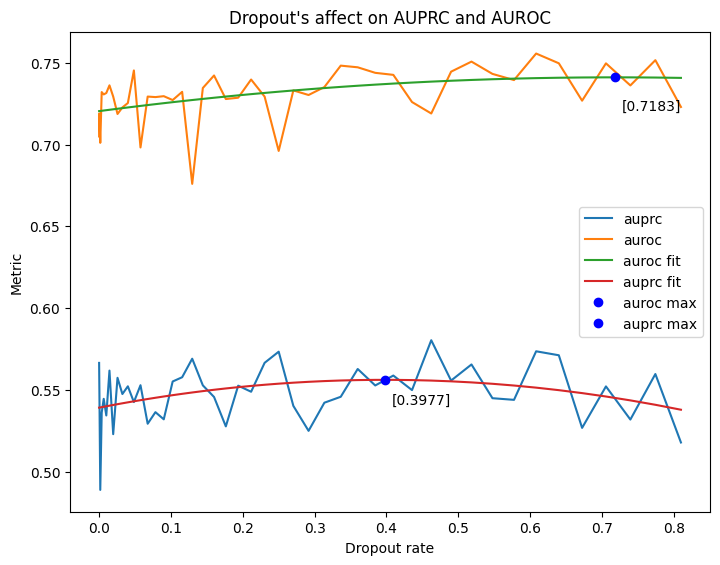

In [27]:
from matplotlib import pyplot as plt
import numpy as np
# plot the results from above

%matplotlib inline

#dropout = list(scores.keys())
#auprc = list(score[1] for score in scores.values())
#auroc = list(score[2] for score in scores.values())

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])


coeffecients = np.polyfit(dropout, auroc, 2)
auroc_fit_fn = np.poly1d(coeffecients) # global max at dropour=0.71817274088867
coeffecients = np.polyfit(dropout, auprc, 2)
auprc_fit_fn = np.poly1d(coeffecients) # global max at dropout=0.39753717472119

auroc_deriv = auroc_fit_fn.deriv().r
auroc_max = auroc_deriv[auroc_deriv.imag==0].real
auprc_deriv = auprc_fit_fn.deriv().r
auprc_max = auprc_deriv[auprc_deriv.imag==0].real


ax.plot(dropout, auprc, label="auprc")
ax.plot(dropout, auroc, label="auroc")
ax.plot(dropout, auroc_fit_fn(dropout), label="auroc fit")
ax.plot(dropout, auprc_fit_fn(dropout), label="auprc fit")
ax.plot(auroc_max, auroc_fit_fn(auroc_max),'bo', label="auroc max")
ax.annotate(str(auroc_max.round(4)),xy=(auroc_max+.01, auroc_fit_fn(auroc_max)-.02))
ax.plot(auprc_max, auprc_fit_fn(auprc_max),'bo', label="auprc max")
ax.annotate(str(auprc_max.round(4)),xy=(auprc_max+.01, auprc_fit_fn(auprc_max)-.015))

ax.set_title("Dropout's affect on AUPRC and AUROC")
ax.set_xlabel("Dropout rate")
ax.set_ylabel("Metric")
plt.legend()